# Crypto Price Prediction

Poloniex API docs: https://docs.poloniex.com/#returnchartdata

## Imports

In [1]:
import datetime
import pandas as pd
import requests
import time

## Getting the Data

In [2]:
current_date = int(datetime.datetime.now().strftime('%s'))
end_dt = current_date
time_interval = 365*5*86400
start_dt = end_dt - time_interval

In [3]:
def get_currency_price_data(currency_pair, start_dt, end_dt):
    '''
    '''
    window = 90*86400
    params = {
        'command': 'returnChartData',
        'currencyPair': currency_pair,
        'period': 300
    }
    price_df = pd.DataFrame()
    
    for start in range(start_dt, end_dt, window):
        params['start'] = start
        params['end'] = start + window
        response = requests.get(url='https://poloniex.com/public', params=params)
        # Should technically inspect the response here but I've noticed that a status_code == 200 doesn't necessarily imply that proper data was returned.  I've encountered errors where the API returned text claiming that the response was too large.
        price_df = pd.concat([price_df, pd.DataFrame(response.json())])
        # Possibly add wait period here before calling API again.  I've found it's unnecessary, though.
    
    return price_df

In [79]:
# 5 years of data is ~40MB.
eth_data = get_currency_price_data(currency_pair='USDT_ETH', start_dt=start_dt, end_dt=end_dt)

In [80]:
eth_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447459 entries, 0 to 7201
Data columns (total 8 columns):
close              447459 non-null float64
date               447459 non-null int64
high               447459 non-null float64
low                447459 non-null float64
open               447459 non-null float64
quoteVolume        447459 non-null float64
volume             447459 non-null float64
weightedAverage    447459 non-null float64
dtypes: float64(7), int64(1)
memory usage: 30.7 MB


In [81]:
# 5 years of data is ~40MB.
btc_data = get_currency_price_data(currency_pair='USDT_BTC', start_dt=start_dt, end_dt=end_dt)

In [82]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496204 entries, 0 to 7201
Data columns (total 8 columns):
close              496204 non-null float64
date               496204 non-null int64
high               496204 non-null float64
low                496204 non-null float64
open               496204 non-null float64
quoteVolume        496204 non-null float64
volume             496204 non-null float64
weightedAverage    496204 non-null float64
dtypes: float64(7), int64(1)
memory usage: 34.1 MB


In [84]:
# btc_data.to_csv('data/btc_price.csv')

In [88]:
btc_data.head(5)

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0.0
0,225.0,1424373000,225.0,225.0,225.0,0.004444,0.999999,225.0
1,225.0,1424373300,225.0,225.0,225.0,0.000000,0.000000,225.0
2,225.0,1424373600,225.0,225.0,225.0,0.000000,0.000000,225.0
3,225.0,1424373900,225.0,225.0,225.0,0.000000,0.000000,225.0


In [4]:
btc_data = pd.read_csv('data/btc_data.csv')
eth_data = pd.read_csv('data/eth_data.csv')

## PACF, ACF, AR Modeling and Stationarity Test

In [5]:
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

In [70]:
# Set default figure size.
from pylab import rcParams
rcParams['figure.figsize'] = 14,6

In [14]:
# # This takes way too long to run and tells us something we already know -- that the previous timestep is useful for predicting the current timestep.
# data = btc_data
# plt.plot(x=data.date, y=data.weightedAverage)
# lag_plot(data.weightedAverage)

In [ ]:
# # This takes too long to run for 500k data points.
# autocorrelation_plot(data.weightedAverage)

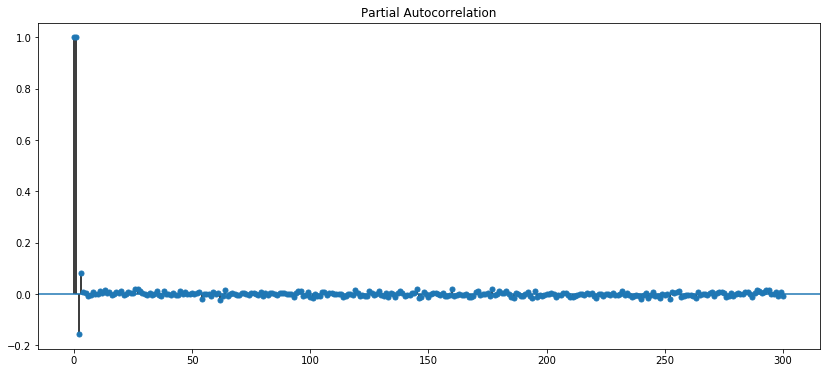

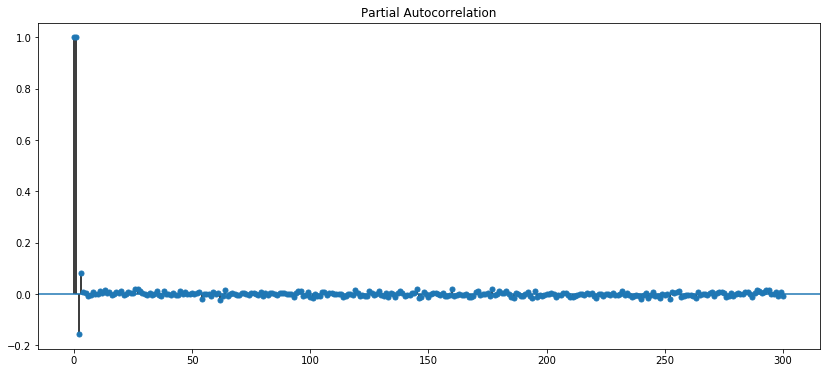

In [31]:
# The first time I plotted this I found something strange.  It was showing lags at 18, 36, ... were important, but this is only the case for BTC prices for the first part of the dataset.  The reason for this is probably that the first BTC price in the dataset is 0.  I also notice that if I plot different segments of the dataset, I get different results for the partial autocorrelation (e.g. plotting 0:50000 is different from 150000:200000, and it seems like the lag trends in the data change as ether evolves.)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data = eth_data
# plot_pacf(data.weightedAverage.tolist()[250000:300000], lags=100)
plot_pacf(data.weightedAverage, lags=300)

Lag: 56
Coefficients: [ 1.73773687e-02  1.09306941e+00 -1.30185454e-01  4.59717585e-02
 -3.37831686e-02  9.09656442e-03  1.70861851e-02  8.74717146e-03
 -1.66993534e-02  2.43818643e-02 -1.82447935e-02 -1.11085021e-02
  9.84363164e-03 -8.73265827e-03  7.48689966e-03 -9.67206697e-03
  1.03187188e-02 -1.00245661e-03 -1.59475280e-03  5.26078819e-03
 -4.40214306e-03  4.21202075e-03  1.26496902e-03 -1.57886730e-02
  1.83096718e-02 -1.60967613e-02  2.99897126e-03  1.09705819e-02
 -6.42498724e-04 -1.74335925e-02  1.93858476e-02 -5.65149470e-03
 -3.96890085e-03  5.69938065e-03  3.57363035e-03 -2.13416414e-02
  2.42561853e-02 -2.29719037e-03  3.20446442e-03 -1.05524552e-02
  1.00993572e-02 -7.45262976e-03  8.40336195e-03 -1.05396505e-02
 -2.20986441e-03 -3.63626146e-03  8.05535617e-03  1.05153618e-02
 -6.61754805e-03 -1.05402586e-02  2.76554208e-02 -2.05554321e-02
  2.00083324e-03  4.95345926e-04 -5.34896618e-03  9.67678055e-03
 -6.02997023e-03]
predicted=186.039756, expected=186.027507
predicte

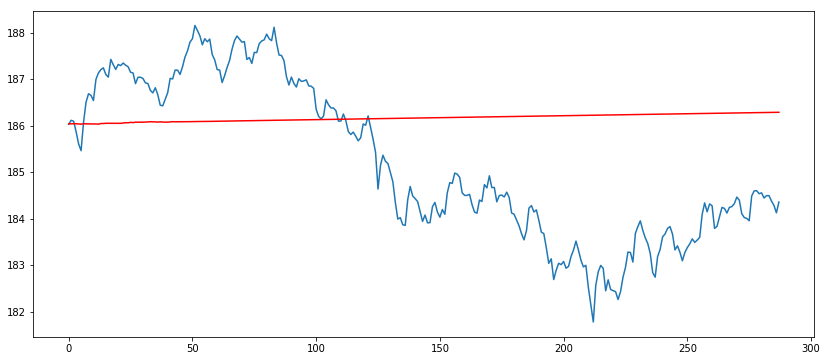

In [33]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

data = eth_data
X = data.weightedAverage.tolist()

# split data
train, test = X[400000:len(X)-288], X[len(X)-288:]

# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [129]:
# # Test for stationarity.  If p > 0.05, the series is **non-stationary**!
# from statsmodels.tsa.stattools import adfuller
# from numpy import log
# result = adfuller(data.weightedAverage.dropna())

## Verifying Data Continuity, Auto (S)ARIMA with AIC

Reference: https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

In [97]:
btc_data_date = btc_data.copy()
# btc_data_date['date'] = btc_data_date['date'].apply(lambda d: datetime.datetime.utcfromtimestamp(d))

In [98]:
from plotly.offline import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

In [88]:
# btc_data_date = btc_data_date.set_index('date')

In [99]:
btc_data_date = btc_data_date.iloc[100000:, ]

In [100]:
btc_data_date.head()

,Unnamed: 0,close,date,high,low,open,quoteVolume,volume,weightedAverage,dt
100000,25732,372.13,1454390400,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
100001,25733,372.13,1454390700,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
100002,25734,372.13,1454391000,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
100003,25735,372.13,1454391300,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
100004,25736,372.13,1454391600,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02


In [101]:
btc_data_date['dt'] = btc_data_date['date'].apply(lambda d: datetime.datetime.utcfromtimestamp(d).date())

In [104]:
grouped = btc_data_date.groupby('dt').count().reset_index()

In [105]:
import plotly.express as px
fig = px.line(grouped, x='dt', y='close')
fig.show()

In [108]:
btc_data_date['date'] = btc_data_date['date'].apply(lambda d: datetime.datetime.utcfromtimestamp(d))
btc_data_date = btc_data_date.set_index('date')

In [110]:
btc_data_date.head()

,Unnamed: 0,close,high,low,open,quoteVolume,volume,weightedAverage,dt
date,,,,,,,,,
2016-02-02 05:20:00,25732,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
2016-02-02 05:25:00,25733,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
2016-02-02 05:30:00,25734,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
2016-02-02 05:35:00,25735,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
2016-02-02 05:40:00,25736,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02


In [130]:
# "ValueError: You must specify a freq" occurs if the time series isn't evenly spaced
# This takes quite a long time to run for 500000 data points and freq of 12*24*365
# I still encounter the ValueError above when it seems like my time series is evenly spaced, but I haven't verified this 100%
# This modeling effort even takes a long time for 100k data points and frequency of 264
result = seasonal_decompose(btc_data_date['weightedAverage'].iloc[300000:, ], model='additive', freq=12*24)
fig = result.plot()
plot_mpl(fig)

'temp-plot.html'

In [128]:
# Couldn't install pyramid.arima.
from pyramid.arima import auto_arima
stepwise_model = auto_arima(btc_data_date.weightedAverage, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

ModuleNotFoundError: No module named 'pyramid.arima'

In [ ]:
train = data.loc['1985-01-01':'2016-12-01']
test = data.loc['2017-01-01':]

In [ ]:
stepwise_model.fit(train)

In [ ]:
future_forecast = stepwise_model.predict(n_periods=37)

In [ ]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=[‘Prediction’])
pd.concat([test,future_forecast],axis=1).iplot()

In [ ]:
pd.concat([data,future_forecast],axis=1).iplot()

## Notes

ARIMA doesn't seem like it's the best approach because it's too linear of a model, requires correct I (integrated) terms which either requires manual intervention or relying on an auto.arima method that 

## References

In [ ]:
# Autoregressive modeling - Jason Brownlee
https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [ ]:
# Thorough step by step tutorial of time series modeling all the way from AR to SARIMAX